In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from decimal import Decimal
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yap15-heart-diseases-predictions/sample_submission.csv
/kaggle/input/yap15-heart-diseases-predictions/train.csv
/kaggle/input/yap15-heart-diseases-predictions/test.csv


## 1.Открываем файлы

In [2]:
from sklearn.pipeline import Pipeline
###Масштабирование###
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
####Модели####
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
os.chdir("/kaggle/input/yap15-heart-diseases-predictions/")
features_test = pd.read_csv('test.csv')
features_train = pd.read_csv('train.csv')

display(features_test)
display(features_train)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.0,130,80,1,1,0,0,1
1,6,19042,2,170,69.0,130,90,1,1,0,0,1
2,7,20432,1,160,70.0,120,75,1,1,0,0,0
3,10,18133,2,185,94.0,130,90,1,1,0,0,1
4,11,16093,2,170,76.0,120,80,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,99984,21722,2,170,103.0,150,90,1,1,0,1,0
29996,99987,18309,1,172,78.0,110,70,1,1,0,0,1
29997,99989,21247,2,169,61.0,120,80,1,1,0,0,0
29998,99994,14509,2,175,80.0,120,80,2,1,0,0,0


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


## 2.

In [4]:

id_train = features_train['id']
id_test = features_test['id']

features_train = features_train[features_train['ap_hi']<=250]
features_train = features_train[features_train['ap_lo']<=250]

features_train = features_train[features_train['ap_lo']>=30]
features_train = features_train[features_train['ap_hi']>=30]

features_train = features_train[features_train['weight']<180]
features_train = features_train[features_train['height']>90]


target_train = features_train['cardio']
features_train = features_train.drop(columns = ['id', 'cardio'])
features_test = features_test.drop(columns = 'id')
display(features_train, features_test)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,18393,2,168,62.0,110,80,1,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1
2,18857,1,165,64.0,130,70,3,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
69995,19240,2,168,76.0,120,80,1,1,1,0,1
69996,22601,1,158,126.0,140,90,2,2,0,0,1
69997,19066,2,183,105.0,180,90,3,1,0,1,0
69998,22431,1,163,72.0,135,80,1,2,0,0,0


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,18888,1,154,85.0,130,80,1,1,0,0,1
1,19042,2,170,69.0,130,90,1,1,0,0,1
2,20432,1,160,70.0,120,75,1,1,0,0,0
3,18133,2,185,94.0,130,90,1,1,0,0,1
4,16093,2,170,76.0,120,80,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
29995,21722,2,170,103.0,150,90,1,1,0,1,0
29996,18309,1,172,78.0,110,70,1,1,0,0,1
29997,21247,2,169,61.0,120,80,1,1,0,0,0
29998,14509,2,175,80.0,120,80,2,1,0,0,0


## 3.Анализ данных

In [5]:
features = [features_train , features_test]
print(f'Процент класса 1 по целевому признаку в тренировочном датасете: {target_train.sum()/target_train.count():.3%}')

Процент класса 1 по целевому признаку в тренировочном датасете: 49.491%


### Давление Features_test

In [6]:
######Нижняя граница давления
def correction_lo(row):
    ap_lo = row['ap_lo']
    ap_hi = row['ap_hi']
    if ap_lo < 40:
        ap_lo = features_train['ap_lo'][features_train['ap_hi'] == ap_hi].median()
    if ap_lo >= 500:
        ap_lo = features_train['ap_lo'][features_train['ap_hi'] == ap_hi].median()
    return ap_lo

# def correction_2_lo(row):
#     ap_lo = row['ap_lo']
#     ap_hi = row['ap_hi']
#     age = row['age']
#     if ap_lo >= 400:
#         ap_lo = features_train['ap_lo'][features_train['ap_hi'] == ap_hi].median()
#     if ap_lo == 0:
#         ap_lo = features_train['ap_lo'][features_train['ap_hi'] == ap_hi].median()
#     return ap_lo

features_test['ap_lo'] = features_test.apply(correction_lo,axis = 1)
# features_test['ap_lo'] = features_test.apply(correction_2_lo,axis = 1)
features_test['ap_lo'] = features_test.groupby('weight')['ap_lo'].apply(lambda x: x.fillna(x.median()))

######Теперь верхняя граница давления
def correction_hi(row):
    ap_lo = row['ap_lo']
    ap_hi = row['ap_hi']
    if ap_hi < 40:
        ap_hi = features_train['ap_hi'][features_train['ap_lo'] == ap_lo].median()
    if ap_hi >= 500:
        ap_hi = features_train['ap_hi'][features_train['ap_lo'] == ap_lo].median()
    return ap_hi

def replace(row):
    if (row['ap_hi'] - row['ap_lo'])<0:
        row['ap_hi'], row['ap_lo'] = row['ap_lo'],row['ap_hi']
    return row

# def correction_2_hi(row):
#     ap_lo = row['ap_lo']
#     ap_hi = row['ap_hi']
#     weight = row['weight']
#     if ap_hi >= 400:
#         ap_hi = features_train['ap_hi'][features_train['ap_lo'] == ap_lo].median()
#     return ap_hi

features_test['ap_hi'] = features_test.apply(correction_hi,axis = 1)
# features_test['ap_hi'] = features_test.apply(correction_2_hi,axis = 1)
features_test = features_test.apply(replace, axis = 1)

### Давление Features_train

In [7]:
features_train = features_train.apply(replace, axis = 1)

In [8]:
def height(row):
    if row['height'] <100 and row['weight'] >100:
        row['height'], row['weight'] = row['weight'],row['height']
    if row['height'] <100:
        row['height'] = features_train['height'][features_train['weight'] == row['weight']].median()
    return row

def weight(row):
    if row['weight']<30:
        row['weight'] = features_train['weight'][features_train['height'] == row['height']].median()
    return row
features_test = features_test.apply(height,axis=1)
features_test = features_test.apply(weight,axis=1) 
    
features_test['hw'] = features_test['height']/features_test['weight'] 

# def hw(row):
#     if row['hw']<1.3:
#         row['weight'] = features_train['weight'][features_train['height'] == row['height']].median()
#     if row['hw']>5:
#         row['weight'] = features_train['weight'][features_train['height'] == row['height']].median()
#     return row
 
# features_test = features_test.apply(hw, axis = 1)
# features_test = features_test.drop(columns=['hw'])

In [25]:
# display(features_test[features_test.isna()])

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
29995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# columns_int = ['age','gender','height','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active']
# dfs = [features_test, features_train]
# for col in columns_int:
#     for df in dfs:
#         df[col] = df[col].astype(int)

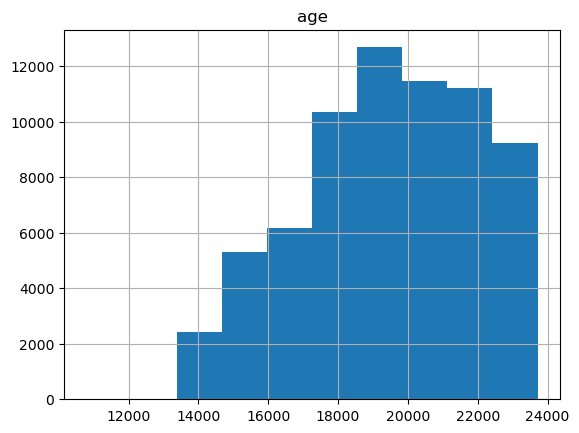

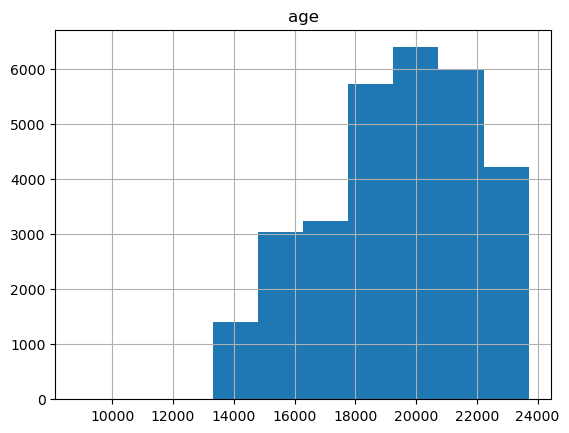

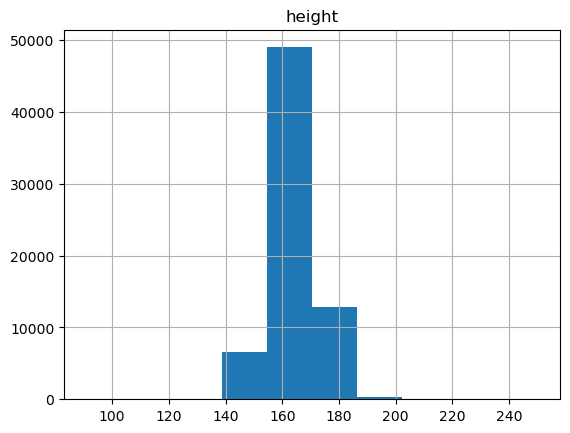

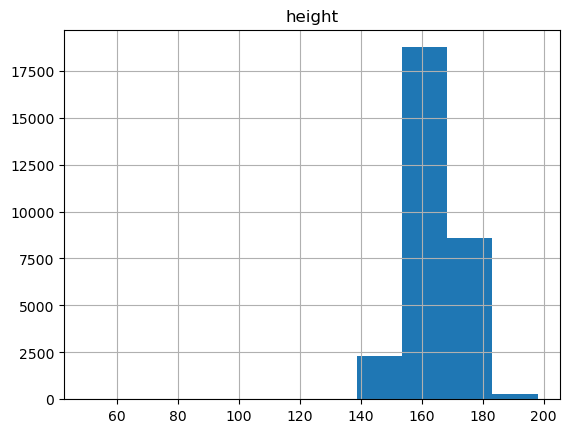

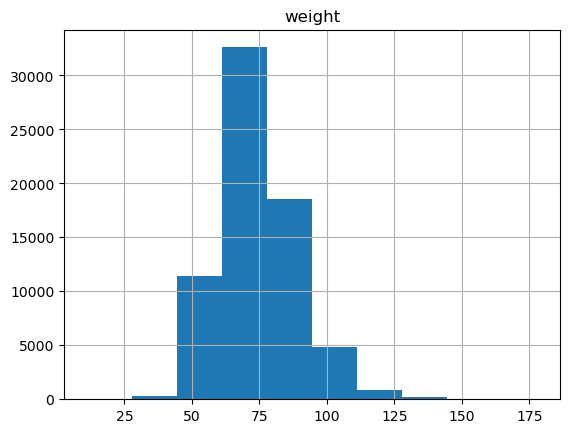

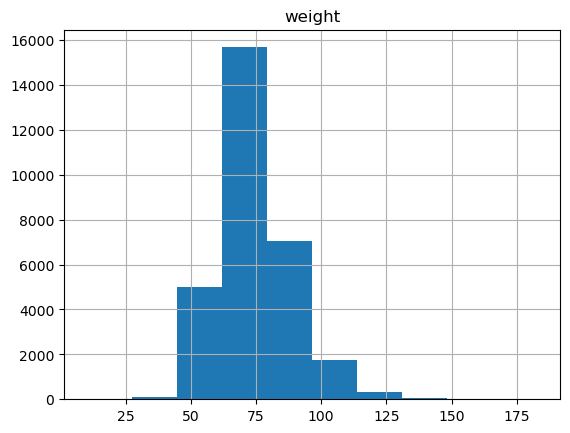

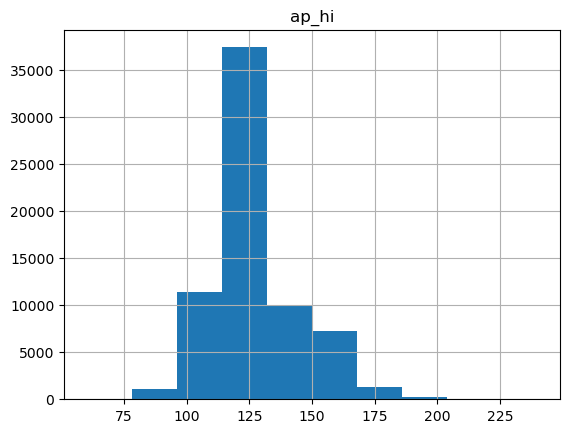

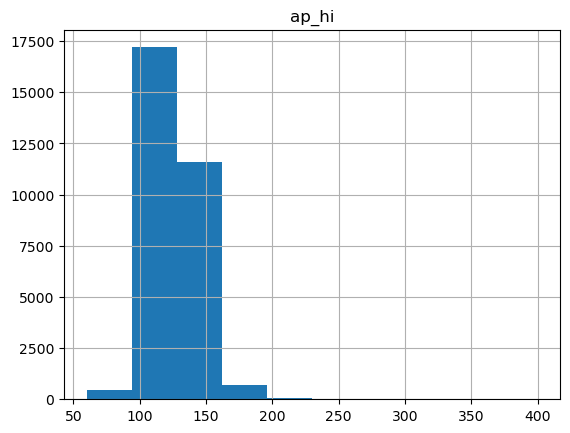

In [11]:
columns_to_hist = ['age','height','weight','ap_hi']

for col in columns_to_hist:
    for df in features:
        df.hist(column=col)
    

In [12]:
categorical_variables = ['gender', 'cholesterol','gluc','smoke','alco','active']
for cat in categorical_variables:
    print(f'Уникальные значения по столбцу {cat}: {pd.unique(features_train[cat])}')

# def gender(g):
#     if g == 2:
#         return 1
#     if g == 1:
#         return 0
# features_train['gender'] = features_train['gender'].apply(gender)
# display(features_train)

Уникальные значения по столбцу gender: [2. 1.]
Уникальные значения по столбцу cholesterol: [1. 3. 2.]
Уникальные значения по столбцу gluc: [1. 2. 3.]
Уникальные значения по столбцу smoke: [0. 1.]
Уникальные значения по столбцу alco: [0. 1.]
Уникальные значения по столбцу active: [1. 0.]


## 4. Масштабирование признаков

### StandartScaler

In [13]:
numeric = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

scaler = StandardScaler()
# one = pd.concat([features_test, features_train])

scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

display(features_train)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,-0.434291,2.0,0.451135,-0.848300,-0.998590,-0.138308,1.0,1.0,0.0,0.0,1.0
1,0.309245,1.0,-1.048639,0.762961,0.797298,0.916329,3.0,1.0,0.0,0.0,1.0
2,-0.246280,1.0,0.076192,-0.708190,0.198669,-1.192944,3.0,1.0,0.0,0.0,0.0
3,-0.746293,2.0,0.576117,0.552797,1.395928,1.970965,1.0,1.0,0.0,0.0,1.0
4,-0.806667,1.0,-1.048639,-1.268629,-1.597220,-2.247580,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
69995,-0.091089,2.0,0.451135,0.132468,-0.399961,-0.138308,1.0,1.0,1.0,0.0,1.0
69996,1.270777,1.0,-0.798677,3.635209,0.797298,0.916329,2.0,2.0,0.0,0.0,1.0
69997,-0.161594,2.0,2.325854,2.164057,3.191817,0.916329,3.0,1.0,0.0,1.0,0.0
69998,1.201894,1.0,-0.173771,-0.147752,0.497983,-0.138308,1.0,2.0,0.0,0.0,0.0


### MinMaxScaler

In [14]:
# def onetwothree(i):
#     if i == 3:
#         return 2
#     if i == 2:
#         return 1
#     if i == 1:
#         return 0
# cols = ['cholesterol', 'gender', 'gluc']

# for col in cols:
#     features_train[col] = features_train[col].apply(onetwothree)
    
# numeric = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
# scaler = MinMaxScaler(feature_range=(0, 2))
# one = pd.concat([features_test, features_train])
# scaler.fit(one[numeric])
# features_train[numeric] = scaler.transform(features_train[numeric])
# features_test[numeric] = scaler.transform(features_test[numeric])
# display(features_train)

## Обучим модели

###  1 RandomForestClassifier

In [15]:
# model = RandomForestClassifier()
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1100, num = 10)]
# max_features = ['sqrt','log2']
# max_depth = [int(x) for x in np.linspace(start = 10, stop = 30, num = 5)]
# min_samples_split = [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 10, stop = 40, num = 10)]
# bootstrap = [True]
# criterion = ['gini', 'entropy']
# parameters = {'n_estimators': n_estimators,
#               'criterion' : criterion,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# random_cv = RandomizedSearchCV(model, 
#                         parameters, 
#                         n_iter = 100, 
#                         scoring = 'f1',
#                         cv = 5, 
#                         verbose = 1, 
#                         n_jobs=-1, 
#                         random_state=42)



# random_cv.fit(features_train,target_train)
# display(random_cv.best_params_)
# results = pd.DataFrame(random_cv.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# results = results.drop([
#             'mean_fit_time', 
#             'std_fit_time', 
#             'mean_score_time',
#             'std_score_time', 
#             'params', 
#             'split0_test_score', 
#             'split1_test_score', 
#             'split2_test_score', 
#             'std_test_score'],
#             axis=1)
# results.head(10)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 100,
 'min_samples_split': 50,
 'min_samples_leaf': 36,
 'max_features': 'log2',
 'max_depth': 15,
 'criterion': 'gini',
 'bootstrap': True}

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_bootstrap,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,100,50,36,log2,15,gini,True,0.721291,0.718188,0.721084,1
1,433,45,23,log2,30,entropy,True,0.719198,0.717846,0.720882,2
2,766,23,33,sqrt,25,gini,True,0.719125,0.717418,0.720848,3
3,211,36,26,log2,15,gini,True,0.719803,0.718000,0.720712,4
4,988,23,36,sqrt,30,gini,True,0.718890,0.717470,0.720676,5
5,766,18,16,sqrt,30,gini,True,0.720025,0.717137,0.720673,6
6,766,50,20,sqrt,25,gini,True,0.720468,0.717646,0.720663,7
7,766,36,30,sqrt,30,gini,True,0.719174,0.716741,0.720663,8
8,544,45,13,sqrt,25,gini,True,0.720111,0.717976,0.720660,9
9,322,50,20,sqrt,30,gini,True,0.720875,0.716132,0.720641,10


Лучшие параметры для RandomForestClassifier()
{'n_estimators': 900,
 'min_samples_split': 34,
 'min_samples_leaf': 18,
 'max_features': 'sqrt',
 'max_depth': 11,
 'bootstrap': True}
 С метрикой auc_roc = 0.802362

### 2. GradientBoostingClassifier

In [16]:
# model = GradientBoostingClassifier()

# loss = ['log_loss', 'deviance', 'exponential']
# n_estimators = [100, 500, 900, 1100, 1500]
# max_depth = [2, 3, 5, 10, 15]
# min_samples_leaf = [1, 2, 4, 6, 8]
# min_samples_split = [2, 4, 6, 10]
# max_features = ['sqrt', 'log2']
# parameters = {'loss': loss,
#             'n_estimators': n_estimators,
#             'max_depth': max_depth,
#             'min_samples_leaf': min_samples_leaf,
#             'min_samples_split': min_samples_split,
#             'max_features': max_features}
# random_cv = RandomizedSearchCV(estimator=model,
#     param_distributions=parameters,
#     cv=5, n_iter=100, 
#     scoring = 'f1',
#     n_jobs = -1,
#     verbose = 1, 
#     return_train_score = True,
#     random_state=42)

# random_cv.fit(features_train,target_train)
# random_cv.best_params_

- Лучшие параметры: GradientBoostingClassifier с масштабированием MinMaxScaler: 
{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 5,
 'loss': 'exponential'} с метрикой auc_roc: 0.802687
- Лучшие параметры: GradientBoostingClassifier с масштабированием StandartScaler: 
 {'n_estimators': 100,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 5,
 'loss': 'deviance'} с метрикой auc_roc: 0.802882
 
 

In [17]:
# results = pd.DataFrame(random_cv.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# results = results.drop([
#             'mean_fit_time', 
#             'std_fit_time', 
#             'mean_score_time',
#             'std_score_time', 
#             'params', 
#             'split0_test_score', 
#             'split1_test_score', 
#             'split2_test_score', 
#             'std_test_score'],
#             axis=1)
# results.head(10)

## 3. LogisticRegression

In [18]:
# model = linear_model.LogisticRegression()
# penalties = ['l1','l2','elasticnet','none']
# solvers = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
# max_iters = [100,1000,2500]
# parameters = {'penalty':penalties,
#               'C' : np.logspace(-4,4,20),
#               'solver': solvers,
#               'max_iter' : max_iters
#              }

# random_cv = RandomizedSearchCV(estimator=model,
#     param_distributions=parameters,
#     cv=5,
#     scoring = 'f1',
#     n_jobs = -1,
#     verbose = 1, 
#     return_train_score = True,
#     random_state=42)

# random_cv.fit(features_train,target_train)
# random_cv.best_params_
        



- Лучшие параметры: LogisticRegression: {'solver': 'liblinear',
 'penalty': 'l1',
 'max_iter': 1000,
 'C': 78.47599703514607} с метрикой auc_roc: 0.782951

In [19]:
# results = pd.DataFrame(random_cv.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# results = results.drop([
#             'mean_fit_time', 
#             'std_fit_time', 
#             'mean_score_time',
#             'std_score_time', 
#             'params', 
#             'split0_test_score', 
#             'split1_test_score', 
#             'split2_test_score', 
#             'std_test_score'],
#             axis=1)
# results.head(10)

## 4. Лучшая модель

Найдем более точные гиперпараметры для лучшей модели

In [20]:
# model = RandomForestClassifier()
# n_estimators = [int(x) for x in np.linspace(start = 400, stop = 1100, num = 100)]
# max_features = ['sqrt']
# max_depth = [int(x) for x in np.linspace(start = 11, stop = 14, num = 1)]
# min_samples_split = [int(x) for x in np.linspace(start = 23, stop = 40, num = 4)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 12, stop = 25, num = 3)]
# bootstrap = [True]
# parameters = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# random_cv = RandomizedSearchCV(model, 
#                         parameters, 
#                         n_iter = 50, 
#                         scoring = 'f1',
#                         cv = 5, 
#                         verbose = 1, 
#                         n_jobs=-1, 
#                         random_state=0)
# random_cv.fit(features_train,target_train)
# print(random_cv.best_params_)

# results = pd.DataFrame(random_cv.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# results = results.drop([
#             'mean_fit_time', 
#             'std_fit_time', 
#             'mean_score_time',
#             'std_score_time', 
#             'params', 
#             'split0_test_score', 
#             'split1_test_score', 
#             'split2_test_score', 
#             'std_test_score'],
#             axis=1)


# results.head(10)

In [21]:
# display(results)

0.725939
0.803021
---
RF
0.724698



In [22]:
# {'n_estimators': 100,
#  'min_samples_split': 50,
#  'min_samples_leaf': 36,
#  'max_features': 'log2',
#  'max_depth': 15,
#  'criterion': 'gini',
#  'bootstrap': True}


model = RandomForestClassifier(n_estimators = 100,
                             min_samples_split = 50,
                             min_samples_leaf = 36,
                             max_features = 'log2',
                             max_depth = 15,
                             criterion= 'gini',
                             bootstrap = True,
                            random_state = 42)
    
model.fit(features_train,target_train)

predictions = model.predict_proba(features_test)
display(predictions)
predictions = predictions[:,1]
display(predictions)


In [23]:
id_test = pd.DataFrame(data=id_test)
id_test['cardio'] = predictions
display(id_test)

In [24]:
os.chdir('/kaggle/working/')
id_test.to_csv('id_test.csv',index=False)